# 1. 데이터로더 구현
* https://www.tensorflow.org/api_docs/python/tf/keras/utils/Sequence


* batch 기반의 딥러닝 모델 학습을 위해 효율적으로 데이터를 읽어오는 역할

* 최소한 정의가 되어야 할 함수들

```
def __init__(self, x_set, y_set, batch_size): # 생성자 -> 준비작업
        self.x, self.y = x_set, y_set
        self.batch_size = batch_size

# len() : 길이를 구해주는 파이썬 내장함수
def __len__(self): # 길이 -> len() 함수를 overriding(재구현)
        return math.ceil(len(self.x) / self.batch_size)

def __getitem__(self, idx): # 아이템 지정
        batch_x = self.x[idx * self.batch_size:(idx + 1) *
        self.batch_size]
        batch_y = self.y[idx * self.batch_size:(idx + 1) *
        self.batch_size]

        return np.array([
            resize(imread(file_name), (200, 200))
               for file_name in batch_x]), np.array(batch_y)
```

In [1]:
import math
import random
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow import keras

### batch_size
* 모델의 가중치를 한 번 업데이트 시킬 때 사용되는 샘플들의 묶음
    * 총 1000개의 학습 샘플이 있을 때 배치 사이즈가 20이라면, 20개의 샘플 단위마다 모델의 가중치를 한 번씩 업데이트 시킴
    * 총 50번(=1000/20) 가중치가 업데이트 됨
    * 하나의 데이터 셋을 총 50개의 배치로 나눠서 학습

### epoch
* 딥러닝에서 학습의 횟수를 의미
    * epoch이 10이고 배치 사이즈가 20이면 가중치를 50번 업데이트 하는 것을 총 10번 반복함
    * 각 데이터 샘플이 총 10번씩 사용되는 것
    * 가중치가 총 500번 업데이트 된다.

> 배치 사이즈가 너무 크면 한 번에 처리해야 할 양이 많기 때문에 학습 속도가 느려지고, 메모리 부족 문제도 겪을 수 있음. 이런 경우에는 배치 사이즈를 조금 줄여서 학습을 더 많은 배치로 나누어 모델을 훈련시키면 된다.

In [2]:
class DataGenerator(keras.utils.Sequence):
    def __init__(self, batch_size, csv_path, fold, image_size, mode='train', shuffle=True):
        self.batch_size = batch_size
        self.fold = fold
        self.image_size = image_size
        self.mode = mode
        self.shuffle = shuffle
        
        self.df = pd.read_csv(csv_path)
        
        if self.mode == 'train':
            self.df = self.df[self.df['fold'] != self.fold]
        elif self.mode == 'val':
            self.df = self.df[self.df['fold'] == self.fold]
        
        self.on_epoch_end()

####################################################################
    # sample() : 전체 row에서 몇 %(0~1)의 데이터를 return 할 것인지 설정
    # reset_index() : drop=True 옵션을 지정하면 인덱스 열을 보통의 자료열로 올리는 것이 아니라 버림
    
    def on_epoch_end(self):
        if self.shuffle: # shuffle = True라면(df 앞의 인덱스를 지워주는 기능 -> 데이터 순서가 shuffle 될 수 있도록!)
            self.df = self.df.sample(frac=1).reset_index(drop=True)


    # len()
    def __len__(self):
            return math.ceil(len(self.df) / self.batch_size)

    def __getitem__(self, idx):
        strt = idx * self.batch_size
        fin = (idx + 1) * self.batch_size
        data = self.df.iloc[strt:fin]
        batch_x, batch_y = self.get_data(data)
        return np.array(batch_x), np.array(batch_y)
        
    def get_data(self, data):
        batch_x = []
        batch_y = []
        
        for _, r in data.iterrows():
            file_name = r['file_name']
            image = cv2.imread(f'data/images/{file_name}.jpg')
            image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
            image = cv2.resize(image, (self.image_size, self.image_size))
            image = image / 255.
        
            label = int(r['species']) - 1
            
            batch_x.append(image)
            batch_y.append(label)
        return batch_x, batch_y

In [3]:
# __getitem__
# 클래스의 인덱스에 접근할 때 자동으로 호출되는 메소드
class GetItemTest:
    def __init__(self):
        print('GetItemTest 클래스의 생성자입니다.')
        self.numbers = [n for n in range(1,11)]
    def __getitem__(self,index):
        print('__getitem__ 메서드 호출')
        return self.numbers[index]

In [4]:
test1 = GetItemTest()
test1[3] # 4

GetItemTest 클래스의 생성자입니다.
__getitem__ 메서드 호출


4

In [5]:
csv_path = 'data/kfolds.csv'

# def __init__(self, batch_size, csv_path, fold, image_size, mode='train', shuffle=True)
train_generator = DataGenerator(
    batch_size = 9,
    csv_path = csv_path,
    fold = 1, 
    image_size = 256,
    mode = 'train',
    shuffle = True # 
)

In [6]:
print(len(train_generator)) # 학습에 사용되는 generator의 데이터 이미지의 개수

654


In [7]:
654 * 9 # train_generator의 데이터 개수 * batch_size

5886

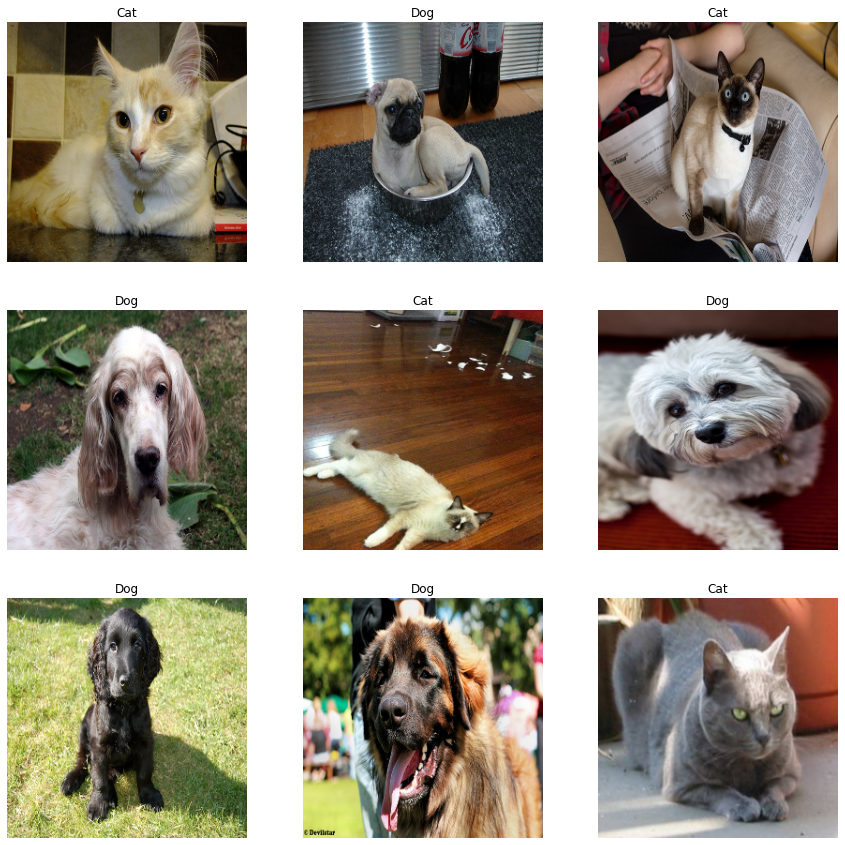

In [8]:
class_name = ['Cat','Dog']

for batch in train_generator:
    X , y = batch
    plt.figure(figsize = (15,15)) # 사진 크기 조정
    
    for i in range(9):
        ax = plt.subplot(3,3,i+1)
        plt.imshow(X[i])
        plt.title(class_name[y[i]])
        plt.axis('off')
    break